In [36]:
import os, re, glob
import numpy as np
import pandas as pd

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from joblib import dump
from sklearn.base import clone

DATA_ROOT = r"data"   

SENSOR_FOLDERS = {
    "act": "act",
    "acw": "acw",
    "pm":  "pm_1.0_1.0",
    "dc":  "dc_0.05_0.05",
}

FNAME_RE = re.compile(r"(?P<ex>\d{2})_(?P<sensor>[a-z]+)_(?:\d+)\.csv$", re.IGNORECASE)


In [37]:
def parse_file_info(path):
    fname = os.path.basename(path)
    m = FNAME_RE.search(fname)
    if not m:
        return None
    ex = int(m.group("ex"))               
    sensor = m.group("sensor").lower()  
    subject = int(os.path.basename(os.path.dirname(path)))  
    return {"subject": subject, "exercise_id": ex, "sensor_tag": sensor, "path": path}

def collect_files(sensor_key):
    folder = os.path.join(DATA_ROOT, SENSOR_FOLDERS[sensor_key])
    paths = glob.glob(os.path.join(folder, "*", "*.csv"))
    infos = []
    for p in sorted(paths):
        info = parse_file_info(p)
        if info is None:
            continue
        infos.append(info)
    return pd.DataFrame(infos)


In [38]:
def read_act_acw_csv(path):
    df = pd.read_csv(path, header=None)

    if df.shape[1] < 4:
        return None, None

    t = df.iloc[:, 0].astype(str).to_numpy()
    M = df.iloc[:, 1:4].apply(pd.to_numeric, errors="coerce")

    if M.isna().mean().mean() > 0.01:
        return None, None

    return t, M.to_numpy(dtype=float)


In [39]:
def read_pm_dc_csv(path):
    df = pd.read_csv(path, header=None)

    if df.shape[1] < 3:
        return None, None

    t = df.iloc[:, 0].astype(str).to_numpy()
    M = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

    M = M.dropna(axis=1, how="all")
    if M.shape[1] == 0:
        return None, None

    M = M.interpolate(limit_direction="both").bfill().ffill()
    return t, M.to_numpy(dtype=float)


In [40]:
def feats_act_like(M, prefix):
    if M.shape[1] < 3:
        return {}

    x, y, z = M[:, 0], M[:, 1], M[:, 2]
    mag = np.sqrt(x*x + y*y + z*z)

    def stats(v, name):
        return {
            f"{prefix}__{name}_mean": float(np.mean(v)),
            f"{prefix}__{name}_std":  float(np.std(v)),
            f"{prefix}__{name}_min":  float(np.min(v)),
            f"{prefix}__{name}_max":  float(np.max(v)),
            f"{prefix}__{name}_med":  float(np.median(v)),
            f"{prefix}__{name}_iqr":  float(np.percentile(v, 75) - np.percentile(v, 25)),
            f"{prefix}__{name}_skew": float(skew(v)) if len(v) > 2 else 0.0,
            f"{prefix}__{name}_kurt": float(kurtosis(v, fisher=True)) if len(v) > 3 else 0.0,
            f"{prefix}__{name}_energy": float(np.mean(v*v)),
        }

    feats = {}
    feats.update(stats(x, "x"))
    feats.update(stats(y, "y"))
    feats.update(stats(z, "z"))
    feats.update(stats(mag, "mag"))

    feats[f"{prefix}__corr_xy"] = float(np.corrcoef(x, y)[0, 1]) if np.std(x) > 0 and np.std(y) > 0 else 0.0
    feats[f"{prefix}__corr_xz"] = float(np.corrcoef(x, z)[0, 1]) if np.std(x) > 0 and np.std(z) > 0 else 0.0
    feats[f"{prefix}__corr_yz"] = float(np.corrcoef(y, z)[0, 1]) if np.std(y) > 0 and np.std(z) > 0 else 0.0

    feats[f"{prefix}__T"] = int(M.shape[0])
    return feats


In [41]:
def feats_frame_sensor(M, prefix, maxval=1.0):
    if M.size == 0:
        return {}

    frame_mean   = M.mean(axis=1)
    frame_std    = M.std(axis=1)
    frame_energy = (M*M).mean(axis=1)

    thr = 0.05 * maxval
    frame_active = (M > thr).mean(axis=1)   

    flat = M.ravel()

    def agg(v, name):
        return {
            f"{prefix}__{name}_mean": float(np.mean(v)),
            f"{prefix}__{name}_std":  float(np.std(v)),
            f"{prefix}__{name}_min":  float(np.min(v)),
            f"{prefix}__{name}_max":  float(np.max(v)),
            f"{prefix}__{name}_med":  float(np.median(v)),
            f"{prefix}__{name}_iqr":  float(np.percentile(v, 75) - np.percentile(v, 25)),
        }

    feats = {}
    feats[f"{prefix}__T"] = int(M.shape[0])
    feats[f"{prefix}__P"] = int(M.shape[1])

    feats.update(agg(flat, "g"))

    feats.update(agg(frame_mean, "frame_mean"))
    feats.update(agg(frame_std, "frame_std"))
    feats.update(agg(frame_energy, "frame_energy"))
    feats.update(agg(frame_active, "frame_active"))

    if M.shape[0] > 1:
        frame_diff = np.abs(np.diff(M, axis=0)).mean(axis=1)  
        feats.update(agg(frame_diff, "frame_diff"))
    else:
        feats.update(agg(np.array([0.0]), "frame_diff"))

    return feats


In [42]:
def extract_features_for_file(path, sensor_key):
    if sensor_key in ["act", "acw"]:
        t, M = read_act_acw_csv(path)
        if M is None:
            return None
        return feats_act_like(M, prefix=sensor_key)

    if sensor_key in ["pm", "dc"]:
        t, M = read_pm_dc_csv(path)
        if M is None:
            return None
        return feats_frame_sensor(M, prefix=sensor_key, maxval=1.0)

    return None


def build_feature_table(sensor_key):
    meta = collect_files(sensor_key)
    rows = []
    skipped = 0

    for _, r in meta.iterrows():
        feats = extract_features_for_file(r["path"], sensor_key)
        if feats is None or len(feats) == 0:
            skipped += 1
            continue

        row = {}
        row.update(feats)  
        row["subject"] = int(r["subject"])
        row["exercise_id"] = int(r["exercise_id"])
        row["path"] = r["path"]

        rows.append(row)

    if len(rows) == 0:
        print(f"[{sensor_key}] WARNING: 0 rows. Check DATA_ROOT and file parsing.")
        df = pd.DataFrame(columns=["subject","exercise_id","path"])
    else:
        df = pd.DataFrame(rows)

    print(f"[{sensor_key}] rows={len(df)} skipped={skipped} total_files={len(meta)}")
    return df


In [43]:
act_df = build_feature_table("act")
acw_df = build_feature_table("acw")
pm_df  = build_feature_table("pm")
dc_df  = build_feature_table("dc")
print(act_df.shape, acw_df.shape, pm_df.shape, dc_df.shape)


[act] rows=239 skipped=0 total_files=239
[acw] rows=239 skipped=0 total_files=239
[pm] rows=239 skipped=0 total_files=239
[dc] rows=239 skipped=0 total_files=239
(239, 43) (239, 43) (239, 41) (239, 41)


In [44]:
act_df

,act__x_mean,act__x_std,act__x_min,act__x_max,act__x_med,act__x_iqr,act__x_skew,act__x_kurt,act__x_energy,act__y_mean,...,act__mag_skew,act__mag_kurt,act__mag_energy,act__corr_xy,act__corr_xz,act__corr_yz,act__T,subject,exercise_id,path
0,-0.494511,0.110524,-0.703125,-0.218750,-0.515625,0.187500,0.499927,-0.851744,0.256757,-0.637237,...,0.950303,1.038859,0.973982,0.280568,-0.062651,0.918387,6701,1,1,data/act/01/01_act_1.csv
1,-0.576045,0.056198,-0.718750,-0.500000,-0.546875,0.109375,-0.649934,-1.124529,0.334986,-0.780041,...,0.742381,4.543596,0.992159,-0.917672,-0.716122,0.836070,6356,1,2,data/act/01/02_act_1.csv
2,-0.623904,0.034719,-0.703125,-0.562500,-0.609375,0.062500,-0.465415,-1.416378,0.390462,-0.750269,...,0.900163,7.859642,0.997386,-0.885551,-0.587690,0.725640,6632,1,3,data/act/01/03_act_1.csv
3,-0.058499,0.018751,-0.140625,-0.031250,-0.046875,0.015625,-1.925029,3.900801,0.003774,-0.116161,...,-0.352847,2.566889,0.976548,0.922654,-0.881462,-0.895964,4971,1,4,data/act/01/04_act_1.csv
4,-0.054304,0.227984,-0.484375,0.453125,-0.078125,0.437500,0.072404,-1.354467,0.054925,0.271945,...,4.371550,33.760779,0.870300,0.942706,-0.493777,-0.291903,6112,1,4,data/act/01/04_act_2.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.018715,0.045083,-0.015625,0.281250,0.000000,0.015625,3.050629,10.053382,0.002383,-0.017266,...,-0.302628,6.563369,0.886876,-0.547615,-0.649694,0.315264,2847,30,4,data/act/30/04_act_1.csv
235,0.046505,0.253460,-0.453125,0.546875,-0.015625,0.484375,0.240319,-1.329075,0.066405,0.161863,...,0.356890,1.223099,0.929978,0.956863,0.897799,0.820433,3594,30,4,data/act/30/04_act_2.csv
236,-0.917976,0.031952,-1.015625,-0.796875,-0.921875,0.046875,0.495387,-0.476221,0.843701,-0.158664,...,0.038919,2.481240,0.994487,-0.809479,0.694161,-0.613269,6725,30,5,data/act/30/05_act_1.csv
237,-0.213387,0.056502,-0.390625,0.000000,-0.218750,0.078125,0.066400,-0.108098,0.048726,-0.964696,...,0.424622,3.109878,0.989139,-0.572938,-0.266277,0.278625,5809,30,6,data/act/30/06_act_1.csv


In [45]:
dc_df

,dc__T,dc__P,dc__g_mean,dc__g_std,dc__g_min,dc__g_max,dc__g_med,dc__g_iqr,dc__frame_mean_mean,dc__frame_mean_std,...,dc__frame_active_iqr,dc__frame_diff_mean,dc__frame_diff_std,dc__frame_diff_min,dc__frame_diff_max,dc__frame_diff_med,dc__frame_diff_iqr,subject,exercise_id,path
0,630,192,0.764720,0.198415,0.0,0.9638,0.8662,0.2365,0.764720,0.011455,...,0.015625,0.025030,0.011928,0.003845,0.071033,0.023202,0.017520,1,1,data/dc_0.05_0.05/01/01_dc_1.csv
1,693,192,0.734961,0.218647,0.0,0.9740,0.7368,0.3134,0.734961,0.007693,...,0.015625,0.013010,0.004995,0.001658,0.032329,0.012443,0.006585,1,2,data/dc_0.05_0.05/01/02_dc_1.csv
2,660,192,0.746973,0.229686,0.0,0.9809,0.7516,0.3095,0.746973,0.012563,...,0.010417,0.013059,0.014960,0.002602,0.273077,0.011480,0.006246,1,3,data/dc_0.05_0.05/01/03_dc_1.csv
3,464,192,0.753164,0.204148,0.0,0.9536,0.8541,0.2662,0.753164,0.011091,...,0.010417,0.017755,0.009110,0.002262,0.095169,0.016302,0.011668,1,4,data/dc_0.05_0.05/01/04_dc_1.csv
4,602,192,0.749239,0.203499,0.0,0.9594,0.8493,0.2662,0.749239,0.009535,...,0.010417,0.018940,0.008402,0.002473,0.055877,0.017507,0.010939,1,4,data/dc_0.05_0.05/01/04_dc_2.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,262,192,0.831584,0.170843,0.0,0.9699,0.9118,0.1481,0.831584,0.008100,...,0.005208,0.021366,0.010725,0.003912,0.067792,0.019731,0.013303,30,4,data/dc_0.05_0.05/30/04_dc_1.csv
235,347,192,0.834607,0.172449,0.0,0.9699,0.9163,0.1605,0.834607,0.011206,...,0.005208,0.020418,0.010926,0.001532,0.063594,0.019440,0.016025,30,4,data/dc_0.05_0.05/30/04_dc_2.csv
236,644,192,0.821934,0.176310,0.0,0.9662,0.9017,0.1407,0.821934,0.016547,...,0.010417,0.012669,0.006745,0.000457,0.041066,0.011453,0.009435,30,5,data/dc_0.05_0.05/30/05_dc_1.csv
237,565,192,0.692621,0.268857,0.0,0.9699,0.8945,0.4318,0.692621,0.010722,...,0.015625,0.020588,0.008331,0.001486,0.056595,0.019895,0.010492,30,6,data/dc_0.05_0.05/30/06_dc_1.csv


In [46]:
acw_df

,acw__x_mean,acw__x_std,acw__x_min,acw__x_max,acw__x_med,acw__x_iqr,acw__x_skew,acw__x_kurt,acw__x_energy,acw__y_mean,...,acw__mag_skew,acw__mag_kurt,acw__mag_energy,acw__corr_xy,acw__corr_xz,acw__corr_yz,acw__T,subject,exercise_id,path
0,0.300703,0.146805,-0.046875,0.546875,0.359375,0.296875,-0.635010,-1.104184,0.111974,-0.117265,...,-0.229564,23.810803,0.840206,0.800182,-0.814745,-0.434526,6274,1,1,data/acw/01/01_acw_1.csv
1,0.154396,0.165853,-0.484375,0.328125,0.218750,0.109375,-1.913117,2.792099,0.051345,-0.587818,...,0.300777,1.128051,1.026962,-0.363666,0.378900,-0.786833,5958,1,2,data/acw/01/02_acw_1.csv
2,-0.326554,0.150642,-0.734375,0.156250,-0.359375,0.187500,0.879115,0.089982,0.129331,-0.537886,...,-1.519196,24.083910,1.045536,-0.750373,0.511878,-0.902518,6218,1,3,data/acw/01/03_acw_1.csv
3,0.351988,0.030685,0.250000,0.421875,0.359375,0.046875,-0.128205,-0.507692,0.124837,-0.202756,...,-0.719479,109.520684,0.844955,-0.227204,-0.597429,0.484184,4660,1,4,data/acw/01/04_acw_1.csv
4,-0.109492,0.065070,-0.281250,0.093750,-0.109375,0.093750,0.005734,-0.577676,0.016223,0.991957,...,6.899304,91.812867,1.002556,0.633544,-0.666735,-0.588805,5733,1,4,data/acw/01/04_acw_2.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.668955,0.030953,0.593750,0.750000,0.671875,0.031250,-0.017969,-0.004637,0.448459,0.244821,...,-0.288550,2.194458,1.067013,-0.652355,0.841434,-0.404175,2670,30,4,data/acw/30/04_acw_1.csv
235,0.099161,0.125290,-0.171875,0.843750,0.093750,0.109375,2.740223,11.229605,0.025531,-0.820303,...,-0.892146,20.733781,0.877536,0.849554,0.603623,0.505730,3370,30,4,data/acw/30/04_acw_2.csv
236,-0.374561,0.160652,-2.671875,0.171875,-0.375000,0.171875,-3.586299,34.578620,0.166105,-0.710478,...,12.358602,263.638889,0.902728,-0.567130,0.667235,-0.802106,6305,30,5,data/acw/30/05_acw_1.csv
237,-0.241395,0.354960,-4.218750,4.515625,-0.250000,0.093750,1.366685,35.357723,0.184268,-0.575670,...,4.000291,28.130426,1.118193,-0.050632,-0.365340,-0.047026,5442,30,6,data/acw/30/06_acw_1.csv


In [47]:
pm_df

,pm__T,pm__P,pm__g_mean,pm__g_std,pm__g_min,pm__g_max,pm__g_med,pm__g_iqr,pm__frame_mean_mean,pm__frame_mean_std,...,pm__frame_active_iqr,pm__frame_diff_mean,pm__frame_diff_std,pm__frame_diff_min,pm__frame_diff_max,pm__frame_diff_med,pm__frame_diff_iqr,subject,exercise_id,path
0,967,512,44.218079,146.551277,0.0,1949.0,0.0,10.0,44.218079,3.292924,...,0.027344,3.045632,1.700818,0.000000,16.507812,2.877930,1.856445,1,1,data/pm_1.0_1.0/01/01_pm_1.csv
1,919,512,56.612004,179.968257,0.0,1867.0,0.0,6.0,56.612004,8.529157,...,0.134766,2.363696,2.447805,0.091797,14.429688,1.292969,2.459473,1,2,data/pm_1.0_1.0/01/02_pm_1.csv
2,959,512,74.010373,196.028217,0.0,1841.0,0.0,38.0,74.010373,4.152472,...,0.019531,1.769307,1.769229,0.068359,18.896484,1.096680,1.443359,1,3,data/pm_1.0_1.0/01/03_pm_1.csv
3,719,512,68.723860,153.548050,0.0,1336.0,0.0,37.0,68.723860,1.986479,...,0.011719,1.590110,0.777986,0.000000,7.806641,1.409180,0.858887,1,4,data/pm_1.0_1.0/01/04_pm_1.csv
4,884,512,75.393234,185.878463,0.0,2088.0,0.0,31.0,75.393234,4.355035,...,0.015625,2.560226,1.683905,0.000000,13.675781,2.095703,1.243164,1,4,data/pm_1.0_1.0/01/04_pm_2.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,412,512,27.999076,128.561267,0.0,1378.0,0.0,0.0,27.999076,2.618208,...,0.013672,1.723531,0.866971,0.000000,5.031250,1.640625,1.147461,30,4,data/pm_1.0_1.0/30/04_pm_1.csv
235,520,512,34.268750,155.818728,0.0,2519.0,0.0,0.0,34.268750,3.346248,...,0.041016,2.105969,1.491348,0.000000,10.289062,1.617188,1.387695,30,4,data/pm_1.0_1.0/30/04_pm_2.csv
236,973,512,8.838370,66.982576,0.0,2119.0,0.0,0.0,8.838370,8.980984,...,0.125000,1.022037,1.287653,0.000000,6.873047,0.587891,1.654785,30,5,data/pm_1.0_1.0/30/05_pm_1.csv
237,840,512,3.407457,52.401747,0.0,1329.0,0.0,0.0,3.407457,0.388991,...,0.005859,0.265225,0.167530,0.000000,1.689453,0.218750,0.176758,30,6,data/pm_1.0_1.0/30/06_pm_1.csv


In [48]:
def merge_modalities_left(base_df, other_dfs: dict):
    keys = ["subject", "exercise_id"]

    feat_cols = [c for c in base_df.columns if c not in keys + ["path"]]
    merged = base_df[keys + feat_cols].copy()

    for name, df in other_dfs.items():
        if df is None or df.shape[0] == 0:
            print(f"[merge] {name} empty -> skipped")
            continue

        feat_cols = [c for c in df.columns if c not in keys + ["path"]]
        keep = df[keys + feat_cols].copy()
        merged = merged.merge(keep, on=keys, how="left")

    return merged

# Full feature set (ALL sensors): ACT + ACW + PM + DC
df_all = merge_modalities_left(act_df, {"acw": acw_df, "pm": pm_df, "dc": dc_df})
print("ALL sensors shape:", df_all.shape)


ALL sensors shape: (645, 158)


In [49]:
import os
os.makedirs("outputs", exist_ok=True)

df_all.to_csv("outputs/mex_features_all_raw.csv", index=False)


In [50]:
df_all

,subject,exercise_id,act__x_mean,act__x_std,act__x_min,act__x_max,act__x_med,act__x_iqr,act__x_skew,act__x_kurt,...,dc__frame_active_min,dc__frame_active_max,dc__frame_active_med,dc__frame_active_iqr,dc__frame_diff_mean,dc__frame_diff_std,dc__frame_diff_min,dc__frame_diff_max,dc__frame_diff_med,dc__frame_diff_iqr
0,1,1,-0.494511,0.110524,-0.703125,-0.218750,-0.515625,0.187500,0.499927,-0.851744,...,0.953125,1.000000,0.984375,0.015625,0.025030,0.011928,0.003845,0.071033,0.023202,0.017520
1,1,2,-0.576045,0.056198,-0.718750,-0.500000,-0.546875,0.109375,-0.649934,-1.124529,...,0.947917,0.994792,0.968750,0.015625,0.013010,0.004995,0.001658,0.032329,0.012443,0.006585
2,1,3,-0.623904,0.034719,-0.703125,-0.562500,-0.609375,0.062500,-0.465415,-1.416378,...,0.541667,0.984375,0.968750,0.010417,0.013059,0.014960,0.002602,0.273077,0.011480,0.006246
3,1,4,-0.058499,0.018751,-0.140625,-0.031250,-0.046875,0.015625,-1.925029,3.900801,...,0.947917,1.000000,0.979167,0.010417,0.017755,0.009110,0.002262,0.095169,0.016302,0.011668
4,1,4,-0.058499,0.018751,-0.140625,-0.031250,-0.046875,0.015625,-1.925029,3.900801,...,0.947917,1.000000,0.979167,0.010417,0.018940,0.008402,0.002473,0.055877,0.017507,0.010939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,30,4,0.046505,0.253460,-0.453125,0.546875,-0.015625,0.484375,0.240319,-1.329075,...,0.973958,1.000000,0.994792,0.005208,0.021366,0.010725,0.003912,0.067792,0.019731,0.013303
641,30,4,0.046505,0.253460,-0.453125,0.546875,-0.015625,0.484375,0.240319,-1.329075,...,0.963542,1.000000,0.994792,0.005208,0.020418,0.010926,0.001532,0.063594,0.019440,0.016025
642,30,5,-0.917976,0.031952,-1.015625,-0.796875,-0.921875,0.046875,0.495387,-0.476221,...,0.958333,1.000000,0.994792,0.010417,0.012669,0.006745,0.000457,0.041066,0.011453,0.009435
643,30,6,-0.213387,0.056502,-0.390625,0.000000,-0.218750,0.078125,0.066400,-0.108098,...,0.932292,0.989583,0.958333,0.015625,0.020588,0.008331,0.001486,0.056595,0.019895,0.010492


In [51]:
df_all_pre = df_all.copy()
num_cols = df_all_pre.select_dtypes(include=[np.number]).columns
df_all_pre[num_cols] = df_all_pre[num_cols].replace([np.inf, -np.inf], np.nan)
df_all_pre[num_cols] = df_all_pre[num_cols].fillna(df_all_pre[num_cols].median(numeric_only=True))

df_all_pre.to_csv("outputs/mex_features_all_preprocessed.csv", index=False)
df_all.to_csv("outputs/mex_features_all_raw.csv", index=False)
print("Saved:")
print(" - outputs/mex_features_all_raw.csv")
print(" - outputs/mex_features_all_preprocessed.csv")


Saved:
 - outputs/mex_features_all_raw.csv
 - outputs/mex_features_all_preprocessed.csv


In [52]:
print(df_all_pre.shape)
print(df_all_pre['exercise_id'].value_counts())

(645, 158)
exercise_id
4    465
1     30
2     30
3     30
5     30
6     30
7     30
Name: count, dtype: int64


In [53]:
df_all_pre

,subject,exercise_id,act__x_mean,act__x_std,act__x_min,act__x_max,act__x_med,act__x_iqr,act__x_skew,act__x_kurt,...,dc__frame_active_min,dc__frame_active_max,dc__frame_active_med,dc__frame_active_iqr,dc__frame_diff_mean,dc__frame_diff_std,dc__frame_diff_min,dc__frame_diff_max,dc__frame_diff_med,dc__frame_diff_iqr
0,1,1,-0.494511,0.110524,-0.703125,-0.218750,-0.515625,0.187500,0.499927,-0.851744,...,0.953125,1.000000,0.984375,0.015625,0.025030,0.011928,0.003845,0.071033,0.023202,0.017520
1,1,2,-0.576045,0.056198,-0.718750,-0.500000,-0.546875,0.109375,-0.649934,-1.124529,...,0.947917,0.994792,0.968750,0.015625,0.013010,0.004995,0.001658,0.032329,0.012443,0.006585
2,1,3,-0.623904,0.034719,-0.703125,-0.562500,-0.609375,0.062500,-0.465415,-1.416378,...,0.541667,0.984375,0.968750,0.010417,0.013059,0.014960,0.002602,0.273077,0.011480,0.006246
3,1,4,-0.058499,0.018751,-0.140625,-0.031250,-0.046875,0.015625,-1.925029,3.900801,...,0.947917,1.000000,0.979167,0.010417,0.017755,0.009110,0.002262,0.095169,0.016302,0.011668
4,1,4,-0.058499,0.018751,-0.140625,-0.031250,-0.046875,0.015625,-1.925029,3.900801,...,0.947917,1.000000,0.979167,0.010417,0.018940,0.008402,0.002473,0.055877,0.017507,0.010939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,30,4,0.046505,0.253460,-0.453125,0.546875,-0.015625,0.484375,0.240319,-1.329075,...,0.973958,1.000000,0.994792,0.005208,0.021366,0.010725,0.003912,0.067792,0.019731,0.013303
641,30,4,0.046505,0.253460,-0.453125,0.546875,-0.015625,0.484375,0.240319,-1.329075,...,0.963542,1.000000,0.994792,0.005208,0.020418,0.010926,0.001532,0.063594,0.019440,0.016025
642,30,5,-0.917976,0.031952,-1.015625,-0.796875,-0.921875,0.046875,0.495387,-0.476221,...,0.958333,1.000000,0.994792,0.010417,0.012669,0.006745,0.000457,0.041066,0.011453,0.009435
643,30,6,-0.213387,0.056502,-0.390625,0.000000,-0.218750,0.078125,0.066400,-0.108098,...,0.932292,0.989583,0.958333,0.015625,0.020588,0.008331,0.001486,0.056595,0.019895,0.010492


In [54]:
X = df_all_pre.drop(columns=["exercise_id","subject","path"], errors="ignore")
X = X.select_dtypes(include=[np.number]) 
y = df_all_pre["exercise_id"].values
groups = df_all_pre["subject"].values

In [55]:
from mpl_toolkits.mplot3d import Axes3D  

def plot_pca_2d(X, y, title="PCA 2D projekcija", sample=5000, random_state=0):
    if sample is not None and X.shape[0] > sample:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(X.shape[0], size=sample, replace=False)
        Xp, yp = X.iloc[idx], y[idx]
    else:
        Xp, yp = X, y

    Xs = StandardScaler().fit_transform(Xp)
    Z = PCA(n_components=2, random_state=random_state).fit_transform(Xs)

    plt.figure(figsize=(7,5))
    for lab in sorted(np.unique(yp)):
        m = (yp == lab)
        plt.scatter(Z[m,0], Z[m,1], s=12, alpha=0.7, label=str(lab))
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("figures/pca_2d.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_pca_3d(X, y, title="PCA 3D projekcija", sample=5000, random_state=0):
    if sample is not None and X.shape[0] > sample:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(X.shape[0], size=sample, replace=False)
        Xp, yp = X.iloc[idx], y[idx]
    else:
        Xp, yp = X, y

    Xs = StandardScaler().fit_transform(Xp)
    Z = PCA(n_components=3, random_state=random_state).fit_transform(Xs)

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    for lab in sorted(np.unique(yp)):
        m = (yp == lab)
        ax.scatter(Z[m,0], Z[m,1], Z[m,2], s=12, alpha=0.7, label=str(lab))

    ax.set_title(title)
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
    ax.legend(bbox_to_anchor=(1.25, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("figures/pca_3d.png", dpi=300, bbox_inches="tight")
    plt.show()


In [56]:
import os
os.makedirs("figures", exist_ok=True)

X: (645, 156) | broj klasa: 7


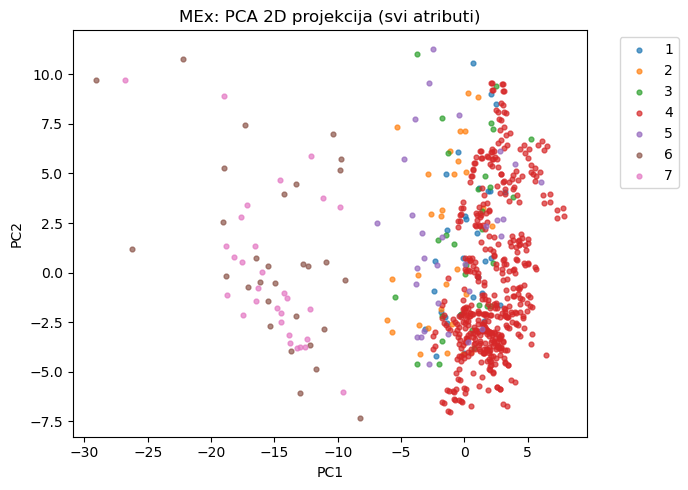

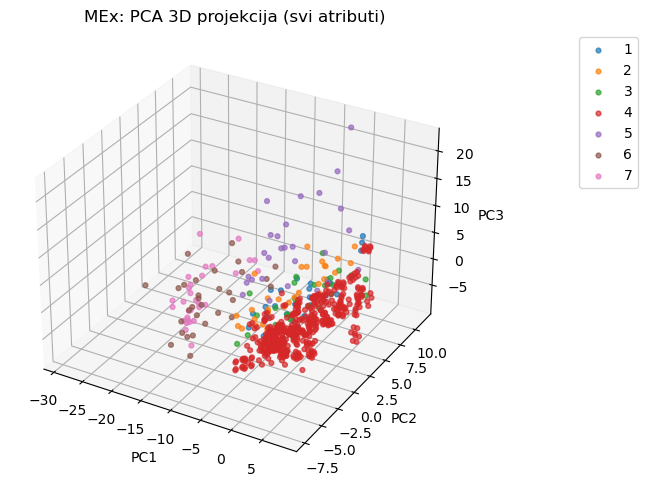

In [57]:
print("X:", X.shape, "| broj klasa:", len(np.unique(y)))

plot_pca_2d(X, y, title="MEx: PCA 2D projekcija (svi atributi)")
plot_pca_3d(X, y, title="MEx: PCA 3D projekcija (svi atributi)")


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (516, 156) Test: (129, 156)


In [59]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

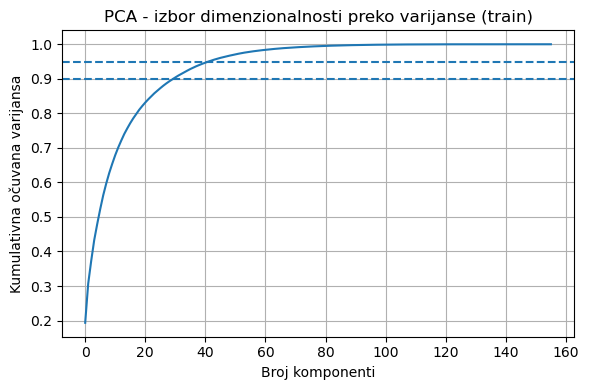

PCA90 dim: 31 | PCA95 dim: 43
Shapes: full (516, 156) | pca90 (516, 31) | pca95 (516, 43) | kbest50 (516, 50)


In [60]:
pca_all = PCA(random_state=0).fit(X_train_sc)
cum_var = np.cumsum(pca_all.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(cum_var)
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.xlabel("Broj komponenti")
plt.ylabel("Kumulativna očuvana varijansa")
plt.title("PCA - izbor dimenzionalnosti preko varijanse (train)")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/pca_variance_curve.png", dpi=300, bbox_inches="tight")
plt.show()

pca90 = PCA(n_components=0.90, random_state=0)
X_train_pca90 = pca90.fit_transform(X_train_sc)
X_test_pca90  = pca90.transform(X_test_sc)

pca95 = PCA(n_components=0.95, random_state=0)
X_train_pca95 = pca95.fit_transform(X_train_sc)
X_test_pca95  = pca95.transform(X_test_sc)

print("PCA90 dim:", X_train_pca90.shape[1], "| PCA95 dim:", X_train_pca95.shape[1])

kbest50 = SelectKBest(mutual_info_classif, k=min(50, X_train_sc.shape[1]))
X_train_kb50 = kbest50.fit_transform(X_train_sc, y_train)
X_test_kb50  = kbest50.transform(X_test_sc)

print("Shapes:",
      "full", X_train_sc.shape,
      "| pca90", X_train_pca90.shape,
      "| pca95", X_train_pca95.shape,
      "| kbest50", X_train_kb50.shape)


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=3000, C=0.01),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200,max_depth=8,min_samples_leaf=5,random_state=42),
    "SVM (RBF)": SVC(kernel="rbf"),
    "Naive Bayes": GaussianNB(),
}


VARIJANTA: Full (svi atributi)

--- Logistic Regression ---
Train acc: 0.9942 | Test acc: 0.9845


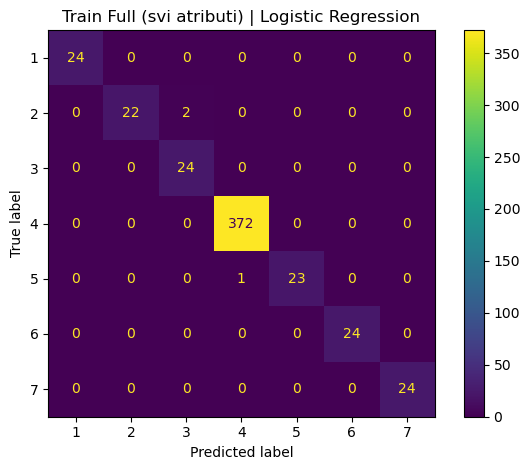

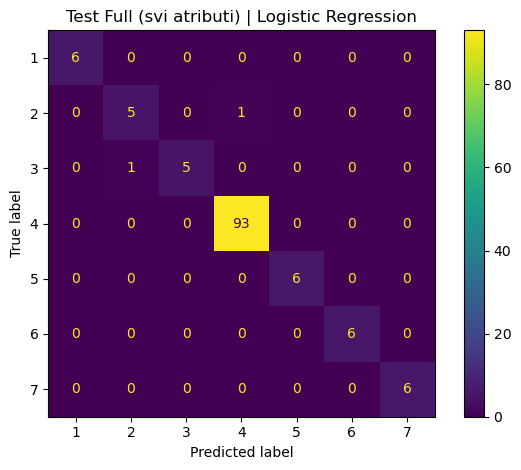


--- K-Nearest Neighbors ---
Train acc: 0.969 | Test acc: 0.938


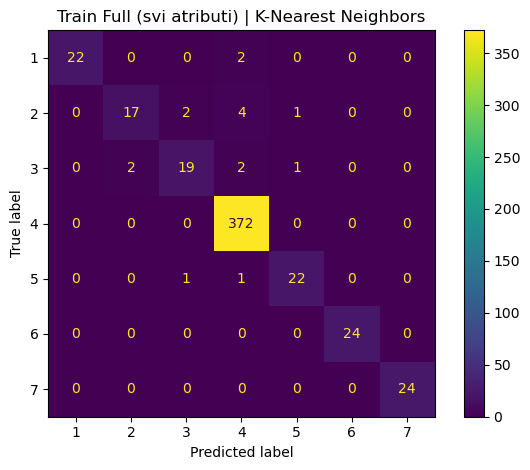

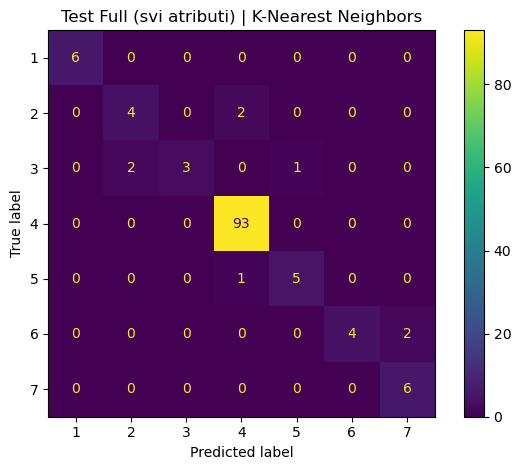


--- Decision Tree ---
Train acc: 1.0 | Test acc: 0.9922


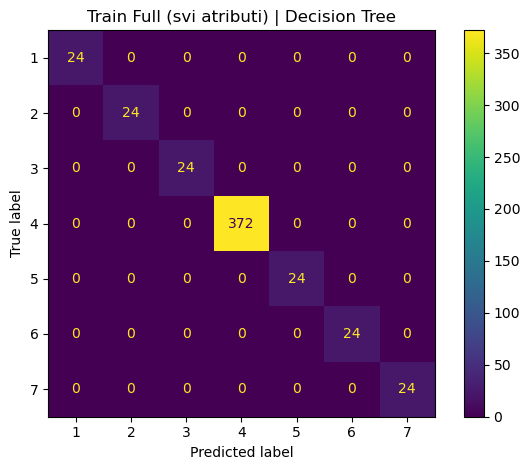

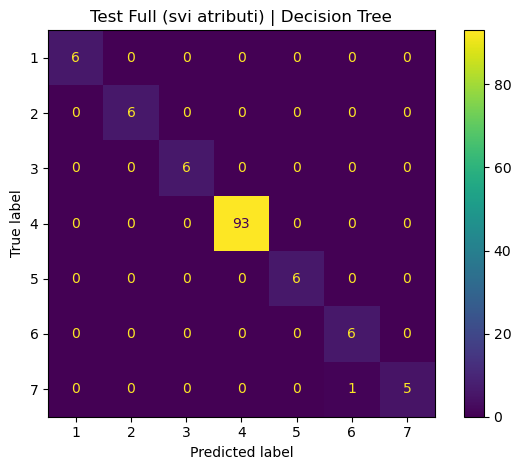


--- Random Forest ---
Train acc: 0.9942 | Test acc: 0.9845


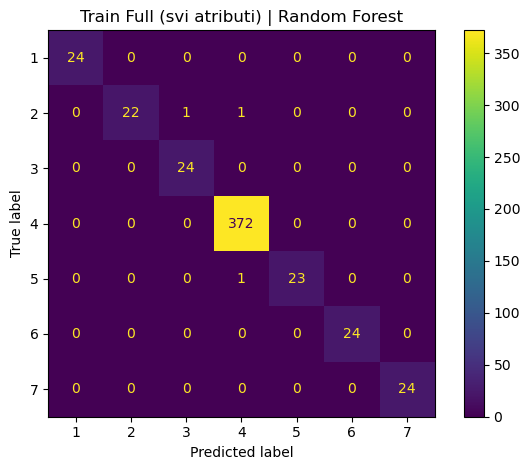

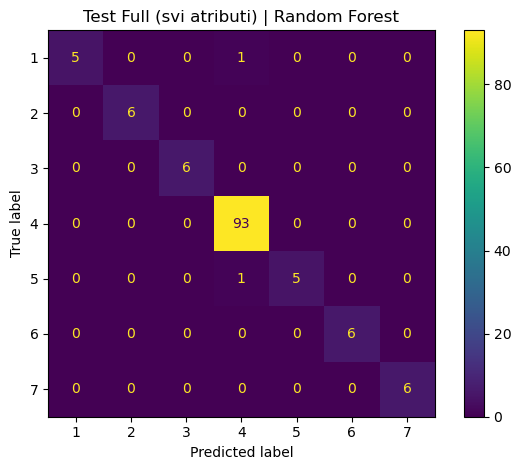


--- SVM (RBF) ---
Train acc: 1.0 | Test acc: 0.9612


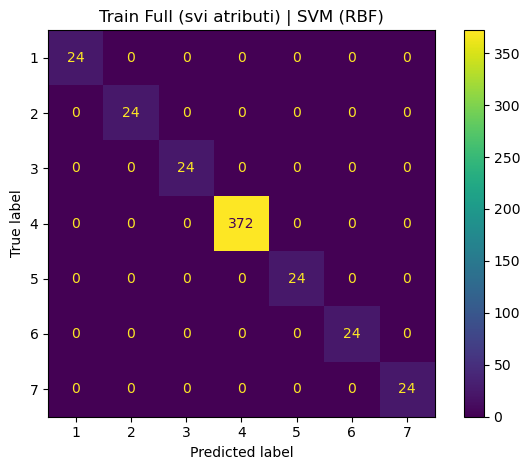

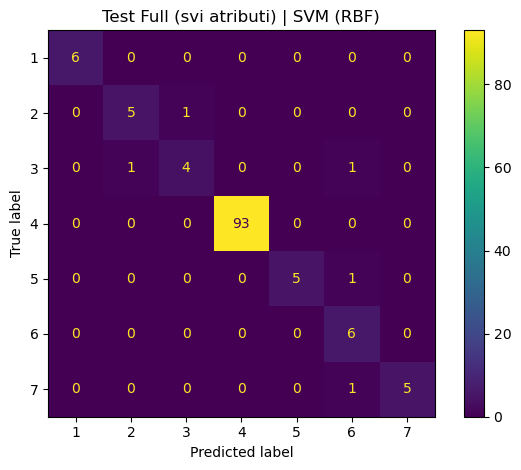


--- Naive Bayes ---
Train acc: 0.9864 | Test acc: 0.9612


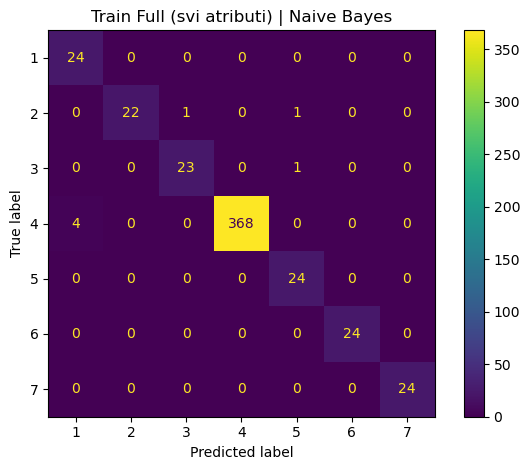

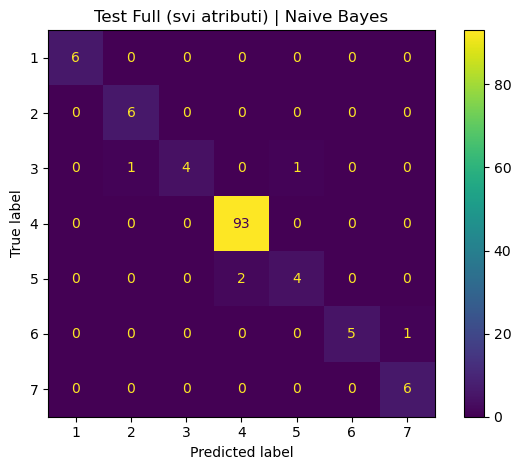


VARIJANTA: PCA90 (90% varijanse)

--- Logistic Regression ---
Train acc: 0.9864 | Test acc: 0.9845


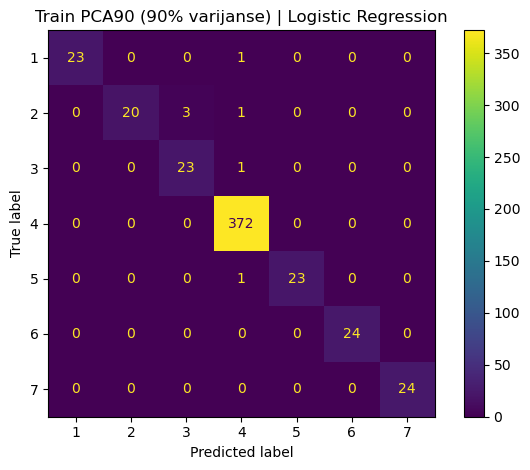

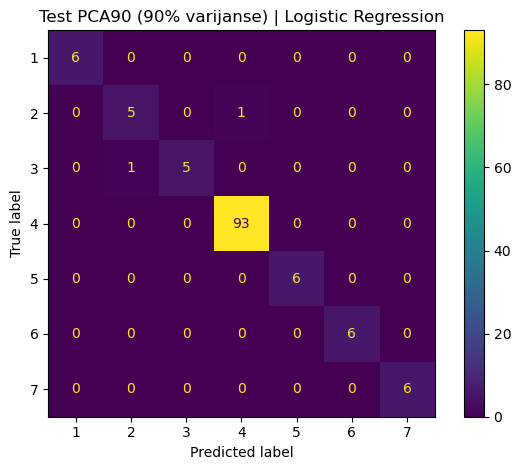


--- K-Nearest Neighbors ---
Train acc: 0.9593 | Test acc: 0.9457


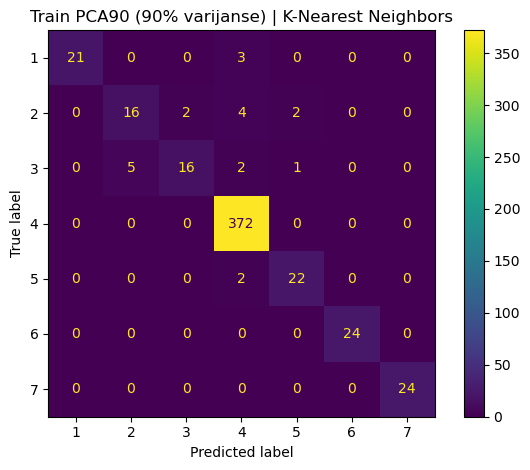

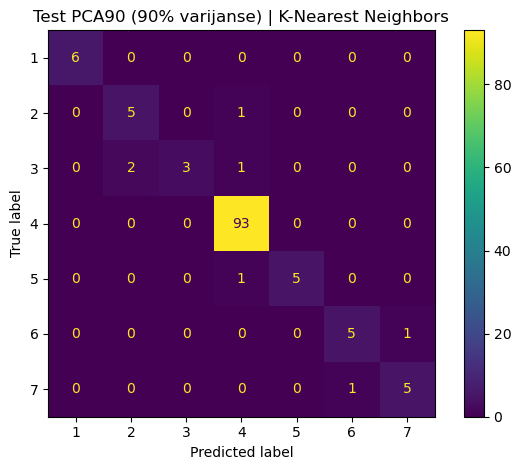


--- Decision Tree ---
Train acc: 1.0 | Test acc: 0.876


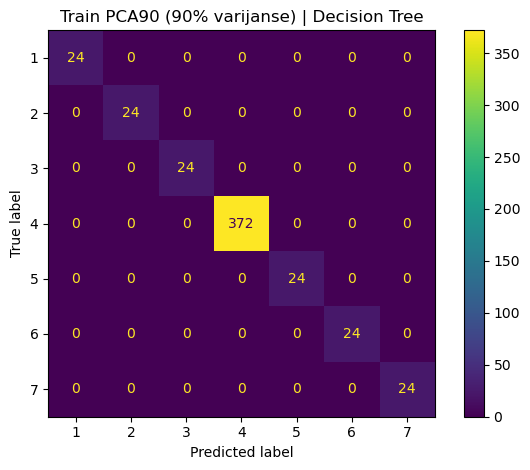

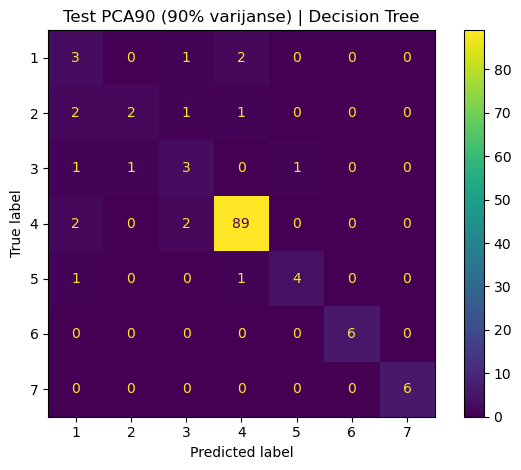


--- Random Forest ---
Train acc: 0.9671 | Test acc: 0.9147


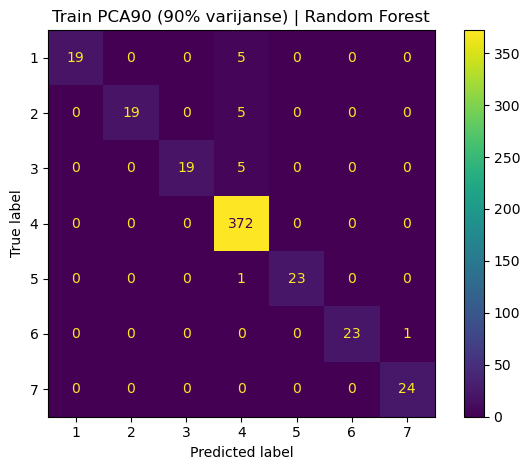

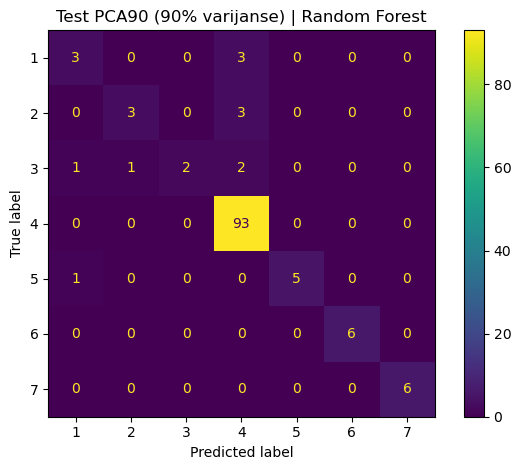


--- SVM (RBF) ---
Train acc: 0.9981 | Test acc: 0.969


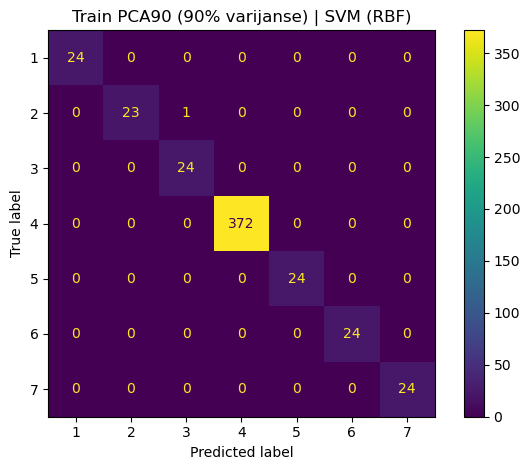

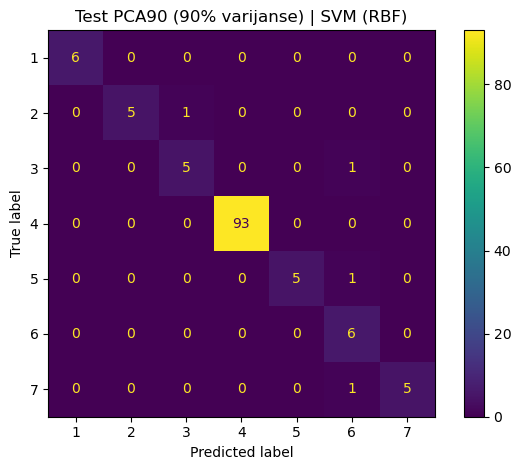


--- Naive Bayes ---
Train acc: 0.9864 | Test acc: 0.9535


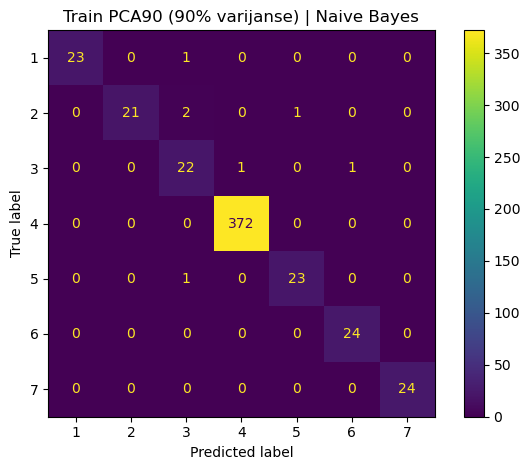

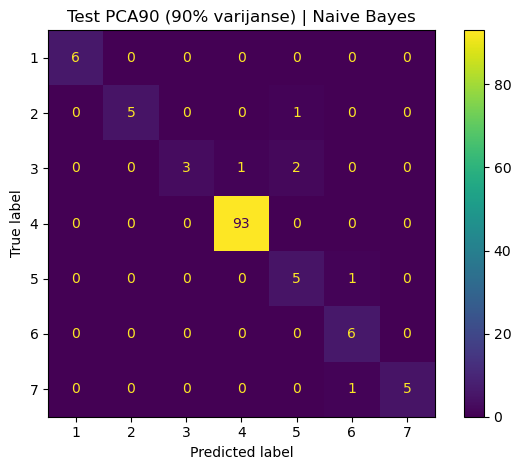


VARIJANTA: PCA95 (95% varijanse)

--- Logistic Regression ---
Train acc: 0.9903 | Test acc: 0.9845


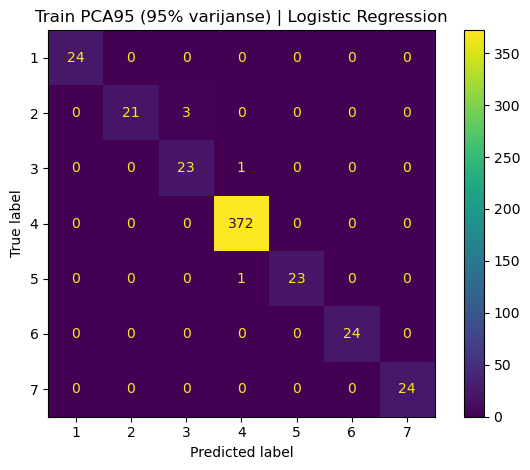

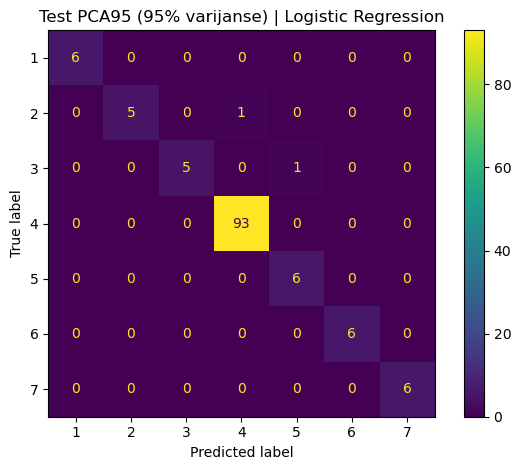


--- K-Nearest Neighbors ---
Train acc: 0.9632 | Test acc: 0.9535


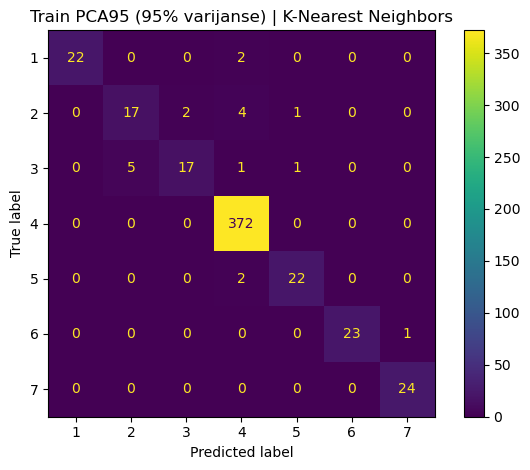

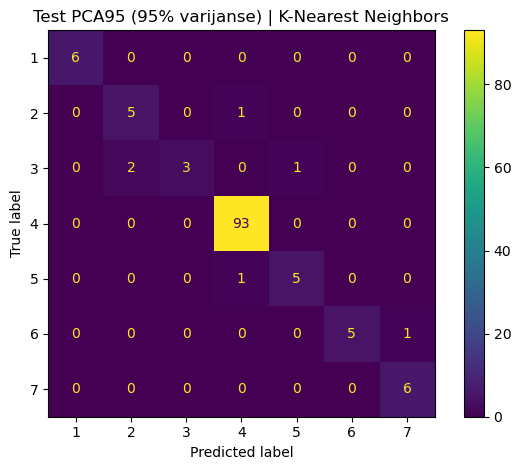


--- Decision Tree ---
Train acc: 1.0 | Test acc: 0.907


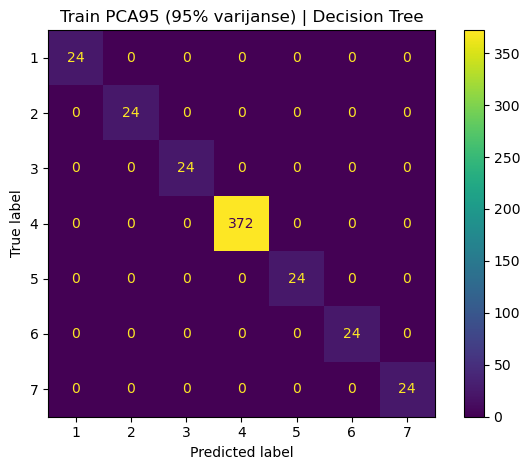

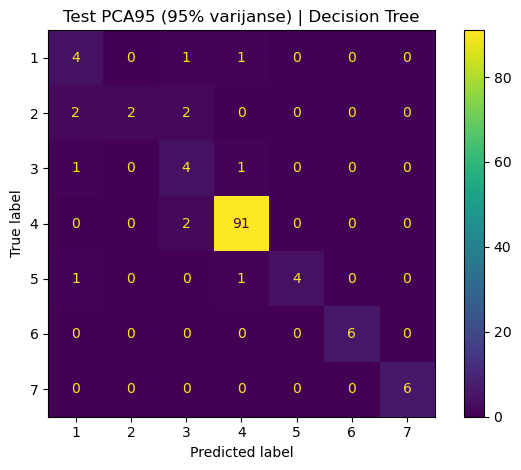


--- Random Forest ---
Train acc: 0.9632 | Test acc: 0.907


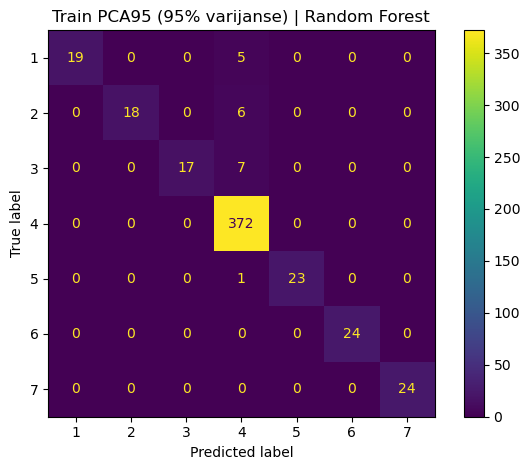

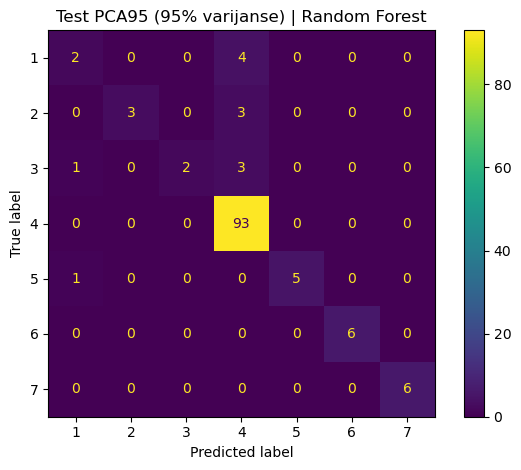


--- SVM (RBF) ---
Train acc: 0.9981 | Test acc: 0.969


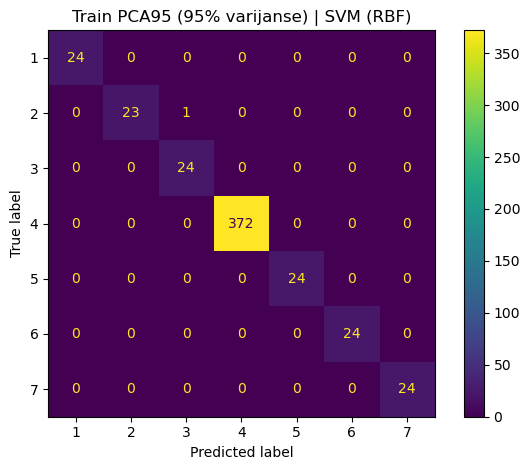

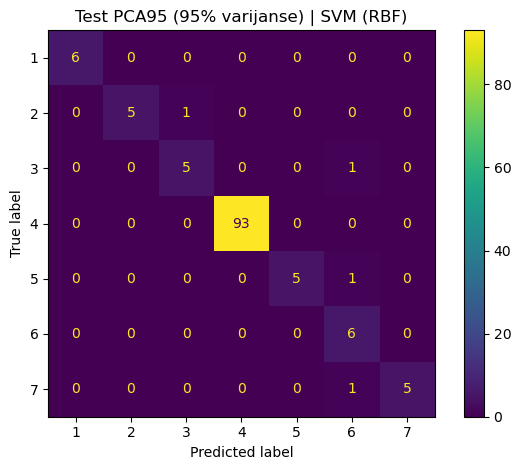


--- Naive Bayes ---
Train acc: 0.9845 | Test acc: 0.9457


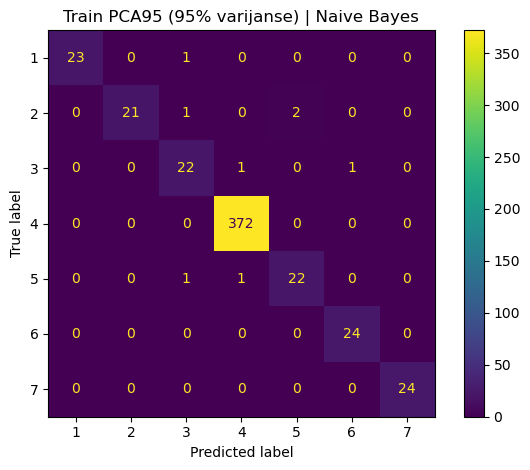

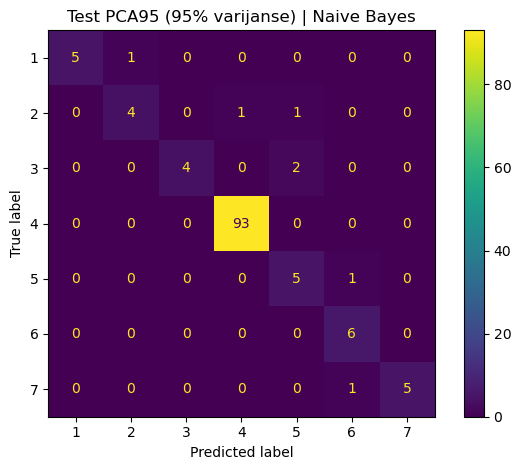


VARIJANTA: KBest50 (mutual_info)

--- Logistic Regression ---
Train acc: 0.9806 | Test acc: 0.9767


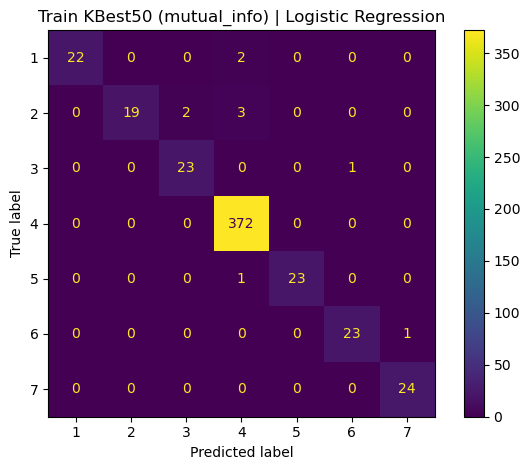

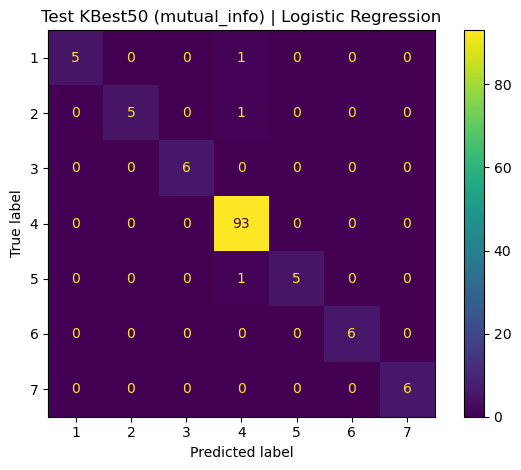


--- K-Nearest Neighbors ---
Train acc: 0.9748 | Test acc: 0.9922


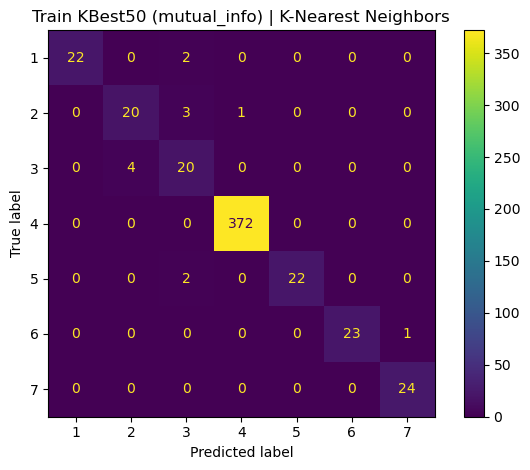

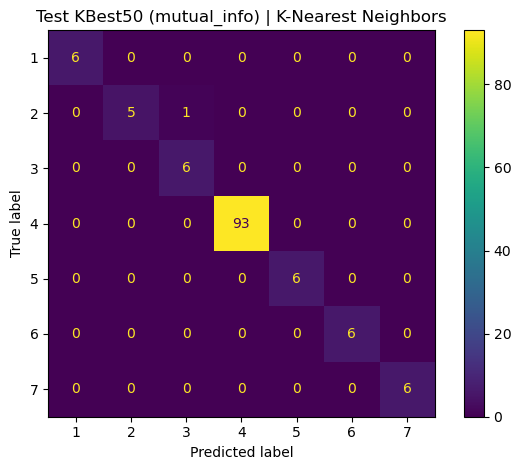


--- Decision Tree ---
Train acc: 1.0 | Test acc: 0.9922


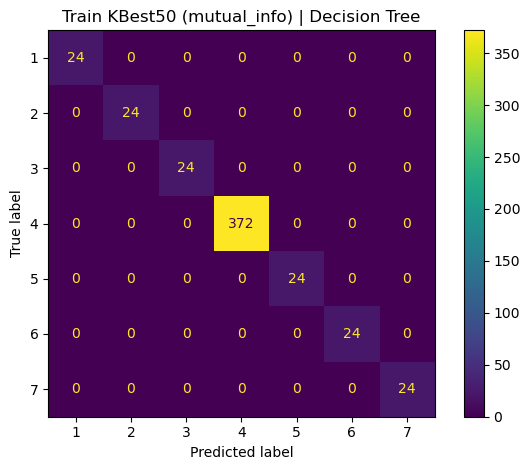

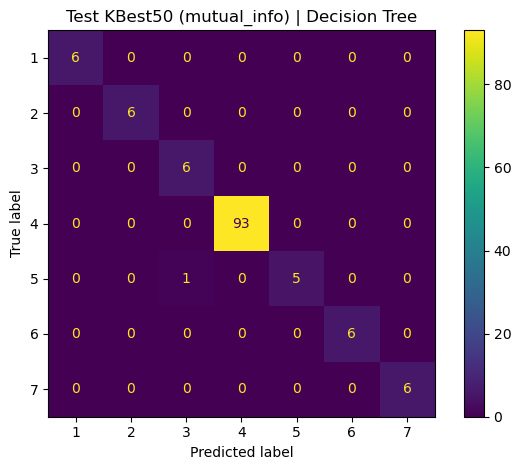


--- Random Forest ---
Train acc: 0.9922 | Test acc: 0.9845


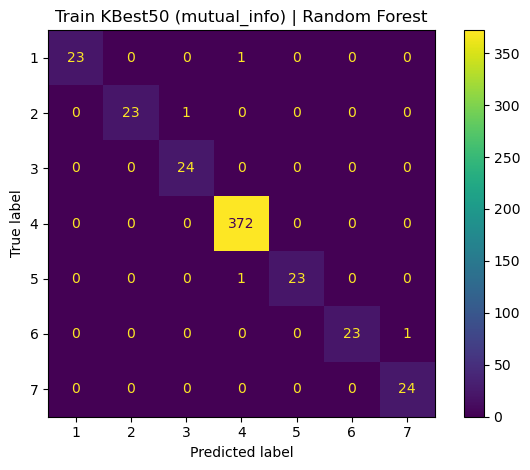

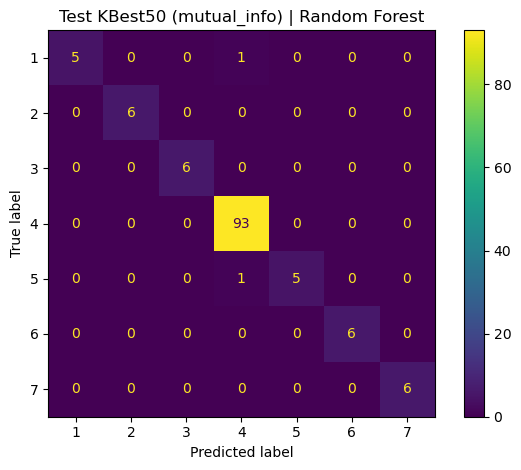


--- SVM (RBF) ---
Train acc: 0.9981 | Test acc: 0.9845


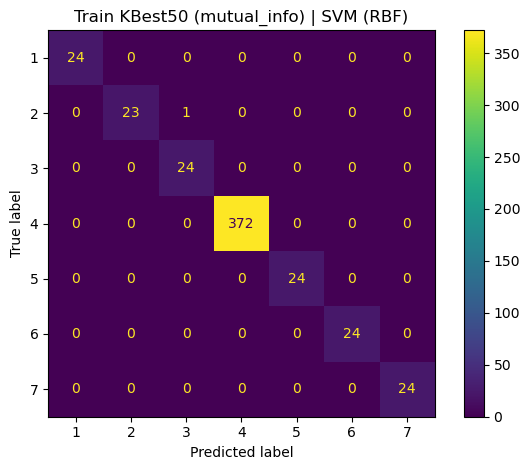

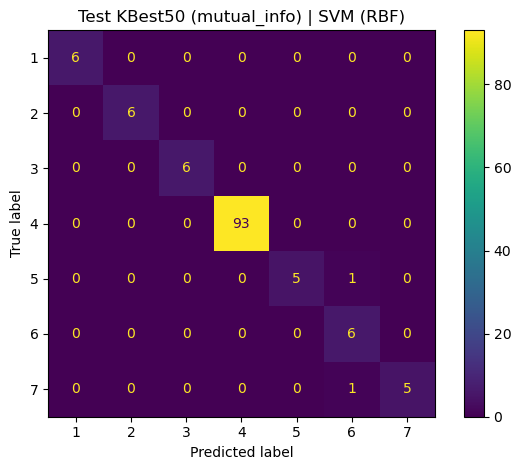


--- Naive Bayes ---
Train acc: 0.9787 | Test acc: 0.9845


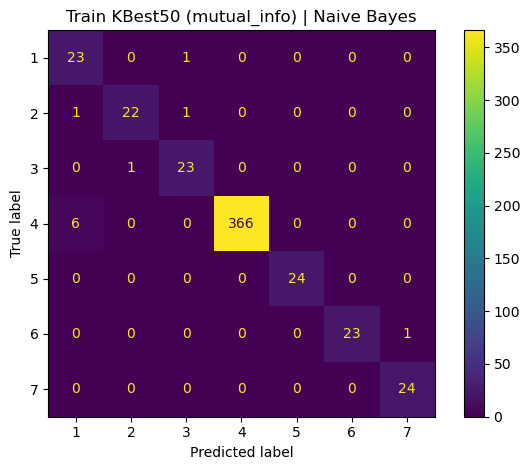

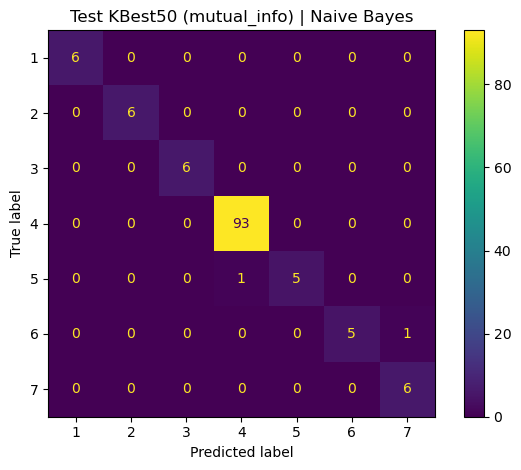

,Varijanta,Algoritam,Test F1-macro,Test Accuracy,Train F1-macro,Train Accuracy
2,Full (svi atributi),Decision Tree,0.976,0.9922,1.0,1.0


In [62]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display

variants = {
    "Full (svi atributi)": (X_train_sc, X_test_sc),
    "PCA90 (90% varijanse)": (X_train_pca90, X_test_pca90),
    "PCA95 (95% varijanse)": (X_train_pca95, X_test_pca95),
    "KBest50 (mutual_info)": (X_train_kb50, X_test_kb50),
}


def eval_model(name, model, Xtr, Xte, ytr, yte, variant_name="", show_cm=True):
    model.fit(Xtr, ytr)

    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)

    out = {
        "Algoritam": name,
        "Train Accuracy": float(accuracy_score(ytr, pred_tr)),
        "Train F1-macro": float(f1_score(ytr, pred_tr, average="macro")),
        "Test Accuracy": float(accuracy_score(yte, pred_te)),
        "Test F1-macro": float(f1_score(yte, pred_te, average="macro")),
    }

    if show_cm:
        print(f"\n--- {name} ---")
        print("Train acc:", round(out["Train Accuracy"],4), "| Test acc:", round(out["Test Accuracy"],4))

        # TRAIN CM
        labels = getattr(model, "classes_", None)
        if labels is None:
            labels = np.unique(np.concatenate([ytr, pred_tr]))
        cm_tr = confusion_matrix(ytr, pred_tr, labels=labels)
        disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=labels)
        disp_tr.plot(cmap="viridis", values_format="d", colorbar=True)
        plt.title(f"Train {variant_name} | {name}")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.tight_layout()
        plt.show()

        # TEST CM
        labels = getattr(model, "classes_", None)
        if labels is None:
            labels = np.unique(np.concatenate([yte, pred_te]))
        cm_te = confusion_matrix(yte, pred_te, labels=labels)
        disp_te = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=labels)
        disp_te.plot(cmap="viridis", values_format="d", colorbar=True)
        plt.title(f"Test {variant_name} | {name}")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.tight_layout()
        plt.show()

    return out

all_results = []

for variant_name, (Xtr, Xte) in variants.items():
    print("\n===============================")
    print("VARIJANTA:", variant_name)
    print("===============================")

    for mname, model in MODELS.items():
        metrics = eval_model(mname, model, Xtr, Xte, y_train, y_test, variant_name=variant_name, show_cm=True)
        metrics["Varijanta"] = variant_name
        all_results.append(metrics)

res_df = pd.DataFrame(all_results)
res_df["Test Accuracy"] = res_df["Test Accuracy"].round(4)
res_df["Test F1-macro"] = res_df["Test F1-macro"].round(4)
res_df["Train Accuracy"] = res_df["Train Accuracy"].round(4)
res_df["Train F1-macro"] = res_df["Train F1-macro"].round(4)

res_df.sort_values(["Varijanta", "Test F1-macro", "Test Accuracy"], ascending=[True, False, False])

best_overall = (res_df
    .sort_values(["Test F1-macro","Test Accuracy"], ascending=[False, False])
    .head(1)
)

display(best_overall[["Varijanta","Algoritam","Test F1-macro","Test Accuracy","Train F1-macro","Train Accuracy"]])

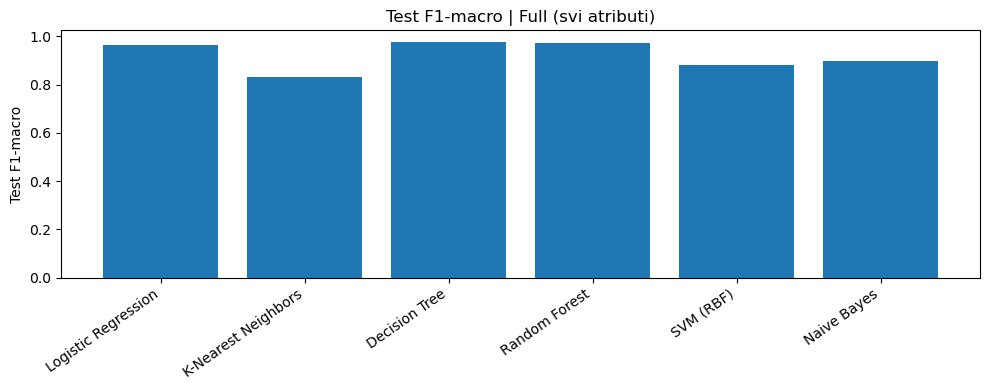

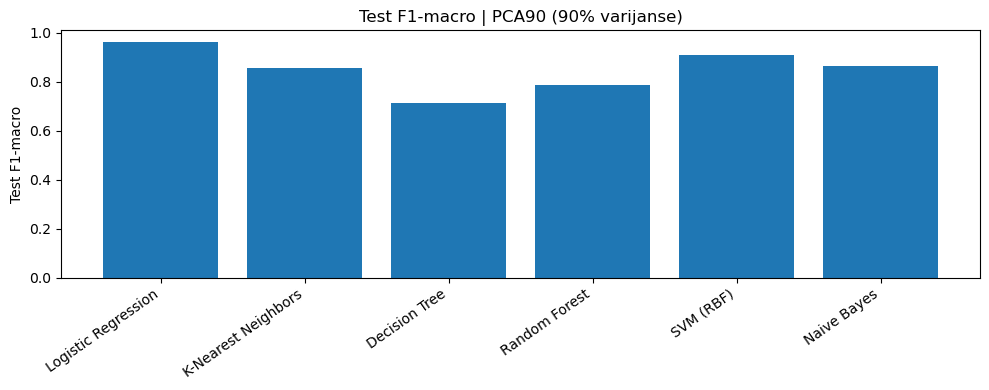

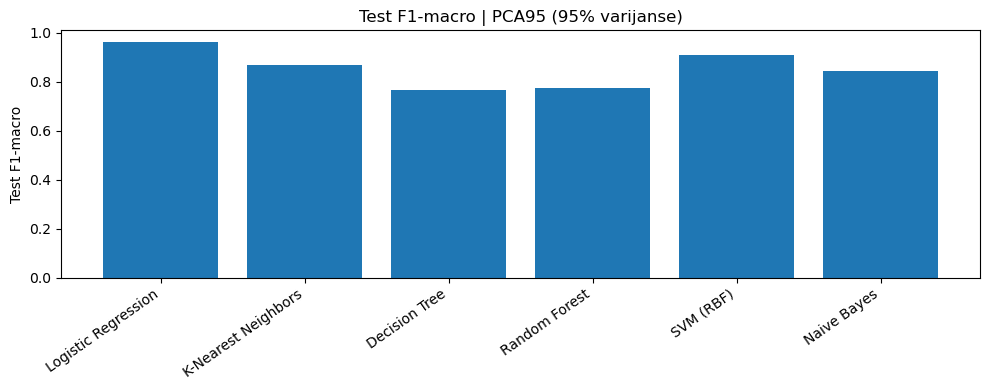

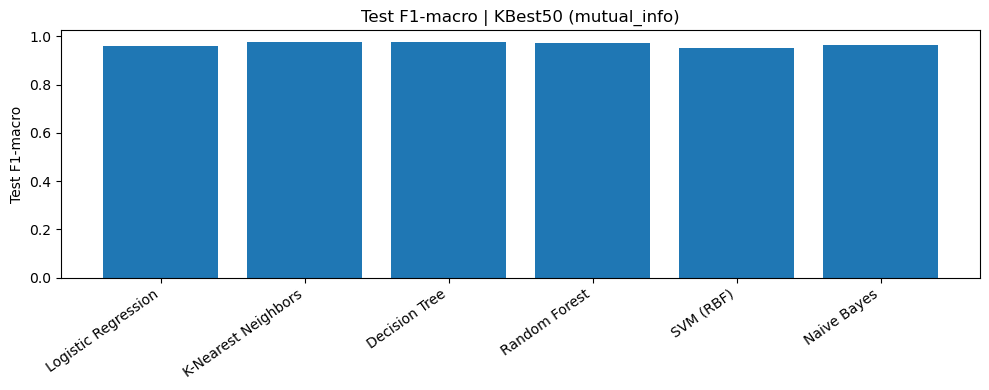

In [63]:
import matplotlib.pyplot as plt
import os

os.makedirs("figures", exist_ok=True)

for v in res_df["Varijanta"].unique():
    tmp = res_df[res_df["Varijanta"] == v]

    plt.figure(figsize=(10,4))
    plt.bar(tmp["Algoritam"], tmp["Test F1-macro"])
    plt.xticks(rotation=35, ha="right")
    plt.ylabel("Test F1-macro")
    plt.title(f"Test F1-macro | {v}")
    plt.tight_layout()
    fname = f"figures/test_f1_plot__{v}.png".replace(" ", "_").replace("%", "")
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

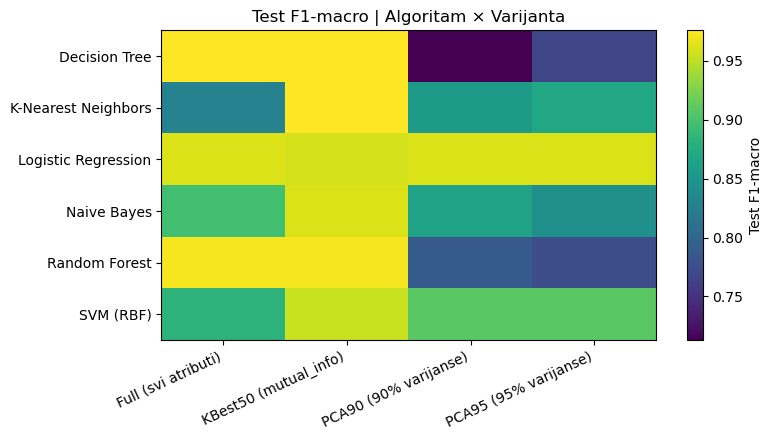

In [64]:
pivot_f1 = res_df.pivot(index="Algoritam",
                        columns="Varijanta",
                        values="Test F1-macro")

plt.figure(figsize=(8,4.5))
plt.imshow(pivot_f1.values, aspect="auto")
plt.colorbar(label="Test F1-macro")
plt.xticks(range(len(pivot_f1.columns)),
           pivot_f1.columns,
           rotation=25,
           ha="right")
plt.yticks(range(len(pivot_f1.index)),
           pivot_f1.index)
plt.title("Test F1-macro | Algoritam × Varijanta")
plt.tight_layout()
plt.savefig("figures/heatmap_test_f1.png", dpi=300)
plt.show()

In [65]:
from sklearn.metrics import classification_report
from sklearn.base import clone
best_per_variant = (res_df
    .sort_values(["Varijanta", "Test F1-macro", "Test Accuracy"], ascending=[True, False, False])
    .groupby("Varijanta", as_index=False)
    .first()
)

best_per_variant[["Varijanta","Algoritam","Test F1-macro","Test Accuracy","Train F1-macro","Train Accuracy"]]
for _, row in best_per_variant.iterrows():
    v = row["Varijanta"]
    alg = row["Algoritam"]

    Xtr, Xte = variants[v]                 
    model = clone(MODELS[alg])             

    model.fit(Xtr, y_train)
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)

    print("\n" + "="*80)
    print(f"NAJBOLJI PO VARIJANTI: {v} | {alg}")
    print("-"*80)
    print("TRAIN classification report:")
    print(classification_report(y_train, pred_tr, digits=4))
    print("\nTEST classification report:")
    print(classification_report(y_test, pred_te, digits=4))


NAJBOLJI PO VARIJANTI: Full (svi atributi) | Decision Tree
--------------------------------------------------------------------------------
TRAIN classification report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        24
           2     1.0000    1.0000    1.0000        24
           3     1.0000    1.0000    1.0000        24
           4     1.0000    1.0000    1.0000       372
           5     1.0000    1.0000    1.0000        24
           6     1.0000    1.0000    1.0000        24
           7     1.0000    1.0000    1.0000        24

    accuracy                         1.0000       516
   macro avg     1.0000    1.0000    1.0000       516
weighted avg     1.0000    1.0000    1.0000       516


TEST classification report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000         6
           2     1.0000    1.0000    1.0000         6
           3     1.0000    1.0000    1.00

Najbolji parametri: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Najbolji CV F1-macro: 0.9292

--- SVM (GridSearch best) @ PCA95 ---
Train acc: 1.0 | Test acc: 0.9845


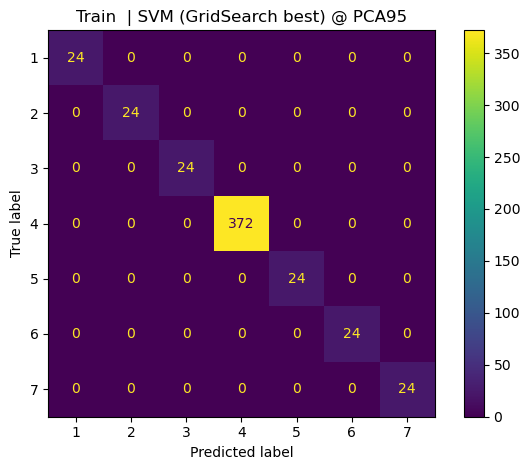

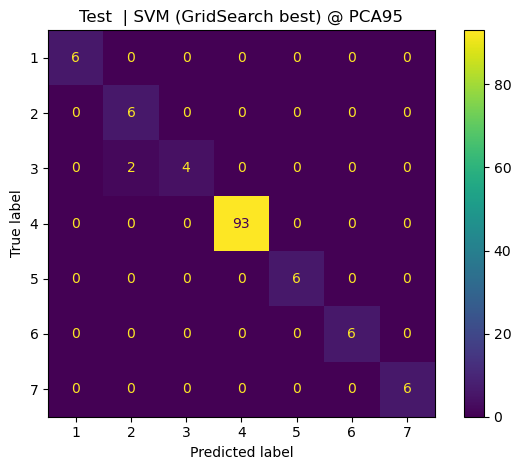

In [66]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV

param_grid = {
    "C": [0.1, 1, 10, 50],
    "kernel": ["rbf", "linear"],
    "gamma": ["scale", "auto"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_pca95, y_train)

print("Najbolji parametri:", grid.best_params_)
print("Najbolji CV F1-macro:", round(grid.best_score_, 4))

best_svm = grid.best_estimator_

_ = eval_model("SVM (GridSearch best) @ PCA95", best_svm, X_train_pca95, X_test_pca95, y_train, y_test, show_cm=True)


In [67]:
import joblib, os
from sklearn.base import clone

os.makedirs("outputs", exist_ok=True)

res_df.to_csv("outputs/model_results_all.csv", index=False)
best_per_variant.to_csv("outputs/best_per_variant.csv", index=False)
best_overall.to_csv("outputs/best_overall.csv", index=False)

joblib.dump(scaler, "outputs/scaler.joblib")
joblib.dump(pca90, "outputs/pca90.joblib")
joblib.dump(pca95, "outputs/pca95.joblib")
joblib.dump(kbest50, "outputs/kbest50_selector.joblib")

best_row = best_overall.iloc[0]
best_variant = best_row["Varijanta"]
best_alg = best_row["Algoritam"]

Xtr_best, Xte_best = variants[best_variant]
best_model = clone(MODELS[best_alg])
best_model.fit(Xtr_best, y_train)
joblib.dump(best_model, f"outputs/best_model_overall__{best_variant}__{best_alg}.joblib")

for _, row in best_per_variant.iterrows():
    v = row["Varijanta"]
    a = row["Algoritam"]
    Xtr_v, Xte_v = variants[v]
    m = clone(MODELS[a])
    m.fit(Xtr_v, y_train)
    joblib.dump(m, f"outputs/best_model__{v}__{a}.joblib")

print("Sačuvano u outputs/: rezultati + scaler/PCA/KBest + najbolji modeli.")

Sačuvano u outputs/: rezultati + scaler/PCA/KBest + najbolji modeli.


In [68]:
res_df

,Algoritam,Train Accuracy,Train F1-macro,Test Accuracy,Test F1-macro,Varijanta
0,Logistic Regression,0.9942,0.9848,0.9845,0.9624,Full (svi atributi)
1,K-Nearest Neighbors,0.9690,0.9254,0.9380,0.8297,Full (svi atributi)
2,Decision Tree,1.0000,1.0000,0.9922,0.9760,Full (svi atributi)
3,Random Forest,0.9942,0.9875,0.9845,0.9725,Full (svi atributi)
4,SVM (RBF),1.0000,1.0000,0.9612,0.8827,Full (svi atributi)
5,Naive Bayes,0.9864,0.9704,0.9612,0.8960,Full (svi atributi)
6,Logistic Regression,0.9864,0.9687,0.9845,0.9624,PCA90 (90% varijanse)
7,K-Nearest Neighbors,0.9593,0.8985,0.9457,0.8565,PCA90 (90% varijanse)
8,Decision Tree,1.0000,1.0000,0.8760,0.7129,PCA90 (90% varijanse)
9,Random Forest,0.9671,0.9382,0.9147,0.7876,PCA90 (90% varijanse)
